In [16]:
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import pandas as pd
import ast
import numpy as np
from tensorflow import keras
import tensorflow as tf

# Montar Google Drive si aún no está montado
from google.colab import drive
drive.mount('/content/drive')

# Cargar el dataset desde Google Drive
dataset_path = '/content/drive/My Drive/compatibility_dataset/compatibility_dataset_len76.csv'

# Cargar el modelo desde el archivo .h5
model = load_model('modelo.h5')

# Congelar todas las capas del modelo
for layer in model.layers[:-1]:
    layer.trainable = False

# Cargar el nuevo dataset
new_df = pd.read_csv(dataset_path)

# Preparar los nuevos datos de entrada y salida
def flatten_and_convert(row):
    try:
        offers_A = ast.literal_eval(row['offers_A'])
        demands_A = ast.literal_eval(row['demands_A'])
        offers_B = ast.literal_eval(row['offers_B'])
        demands_B = ast.literal_eval(row['demands_B'])

        flat_data = np.concatenate([offers_A, demands_A, offers_B, demands_B])
        return flat_data.astype(np.int32)
    except:
        return None

new_X = new_df.apply(flatten_and_convert, axis=1).dropna().values
new_y = new_df['compatibility_percent'].dropna().values

# Crear un nuevo modelo
new_model = Sequential()

# Añadir todas las capas del modelo existente excepto la última
for layer in model.layers[:-1]:
    new_model.add(layer)

# Añadir nuevas capas
new_model.add(keras.layers.Dense(64, activation='relu'))
new_model.add(keras.layers.Dense(32, activation='relu'))

# Añadir la capa de salida del modelo original
new_model.add(model.layers[-1])

# Reduce la tasa de aprendizaje
custom_optimizer = Adam(learning_rate=0.001)

# Compilar el nuevo modelo
#new_model.compile(loss='mean_squared_error', optimizer=custom_optimizer)
new_model.compile(loss='mean_absolute_error', optimizer=custom_optimizer)


# Convertir las matrices NumPy en tensores de TensorFlow
new_X_tf = tf.constant(new_X.tolist())
new_y_tf = tf.constant(new_y)

# Controla el entrenamiento según la convergencia
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Entrenar el nuevo modelo con los nuevos datos
history = new_model.fit(new_X_tf, new_y_tf, batch_size=128, epochs=80, validation_split=0.2, callbacks=[early_stopping])

# Guardar el nuevo modelo
new_model.save('new_model.h5')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/80
32/32 [==============================] - 1s 9ms/step - loss: 46.9428 - val_loss: 44.2458
Epoch 2/80
32/32 [==============================] - 0s 5ms/step - loss: 40.7370 - val_loss: 36.8558
Epoch 3/80
32/32 [==============================] - 0s 5ms/step - loss: 31.7765 - val_loss: 27.2207
Epoch 4/80
32/32 [==============================] - 0s 4ms/step - loss: 23.1174 - val_loss: 24.0712
Epoch 5/80
32/32 [==============================] - 0s 4ms/step - loss: 21.6238 - val_loss: 24.0123
Epoch 6/80
32/32 [==============================] - 0s 5ms/step - loss: 21.5660 - val_loss: 24.0066
Epoch 7/80
32/32 [==============================] - 0s 4ms/step - loss: 21.6041 - val_loss: 24.0076
Epoch 8/80
32/32 [==============================] - 0s 5ms/step - loss: 21.6071 - val_loss: 24.0070
Epoch 9/80
32/32 [==============================] - 0s 5ms/step - loss:

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
# Construir el modelo manualmente
new_model.build(input_shape=(None, 152))

# Resumen del modelo
new_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_82 (Dense)            (None, 128)               19584     
                                                                 
 batch_normalization_12 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                                 
 dense_83 (Dense)            (None, 64)                8256      
                                                                 
 dense_84 (Dense)            (None, 32)                2080      
                                                                 
 dense_85 (Dense)            (None, 16)                528       
                                                     

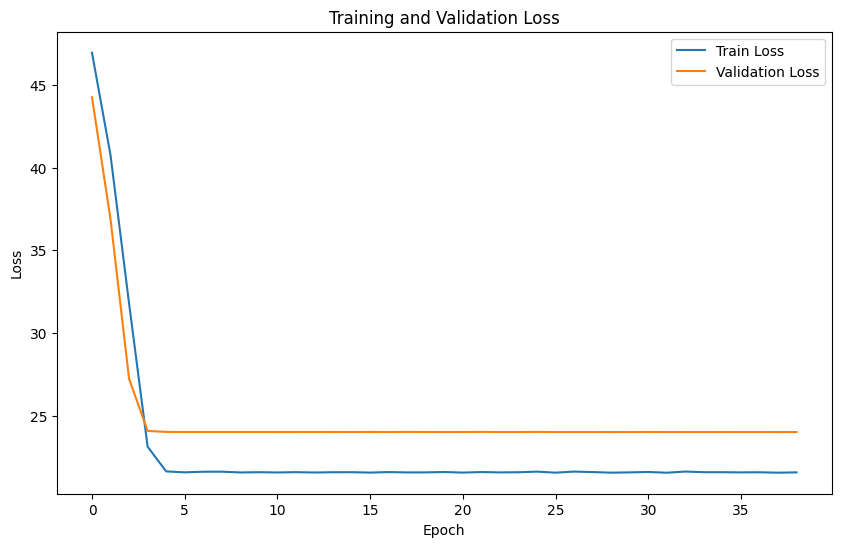

In [17]:
import matplotlib.pyplot as plt

# Obtener las funciones de pérdida y precisión del historial de entrenamiento
loss = history.history['loss']
val_loss = history.history['val_loss']
#accuracy = history.history['accuracy']  # Solo si estás trabajando en un problema de clasificación

# Generar el gráfico de la función de pérdida
plt.figure(figsize=(10, 6))
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()